In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
rectangular_ = 1
elliptic_ = 2

# read impact lattice

In [2]:
beam,lattice = impact.readInputFile('test.Chad.in')

reading ImpactZ input file (test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [3]:
impact.data.elem_type


   0: 'drift'
   1: 'quad'
   2: 'const_focusing'
   3: 'solenoid'
   4: 'dipole'
   5: 'multipole_thin'
   6: 'nonlinear_insert'
   9: 'nonlinear_insert_smooth_focusing'
 101: 'DTL'
 102: 'CCDTL'
 103: 'CCL'
 104: 'SCRF'
 105: 'solenoidRF'
 106: 'TWS'
 110: 'EMfld'
  -1: 'centroid_to_0'
  -2: 'write_raw_ptcl'
  -7: 'save4restart'
  -8: '-8'
  -9: 'pipe_override'
 -16: 'loop'
 -17: 'pipeinfo'
 -21: 'centroid_shift'
 -40: 'RFkick'
 -46: 'linear_matrix_map'
 -87: 'TBT_integral_onMomentum'
 -88: 'TBT_integral'
 -89: 'TBT'
 -90: 'TBT_multiple_file'
 -99: 'halt'

In [26]:
cleanLat = []
pre = lattice[0]
L = 0 
for item in lattice:
    if pre.type == 'drift' and item.type == 'drift':
        cleanLat[-1].length = cleanLat[-1].length + item.length
    elif item.type not in ['-8', 'write_raw_ptcl', 'halt']:
        cleanLat.append(item)
    pre = item
    if 'length' in item:
        L = L+item.length
print(L)

39.968229715800085


In [27]:
L = 0
B30 = [(0.0,0.0)]
B30Loc = []
for item in cleanLat:
    if 'dipole' == item.type:
        if 29.99 < item.bending_angle*180/np.pi < 30.01:
            B30.append((L,0.0))
            B30.append((L,0.035))
            B30.append((L+item.length,0.035))
            B30.append((L+item.length,0.0))
            B30Loc.append([L,L+item.length])
    if 'length' in item:
        L = L + item.length
B30 = np.array(B30)
B30.shape

(17, 2)

# read Aperture

In [28]:
AP = {'x':[],'y':[]}
flagX = False
flagY = False

with open('IOTA_aperture.data') as f:
    while True:
        line = f.readline()
        if line == '':
            break
        if line == '\n':
            flagX = False
            flagY = False
        if flagX:      
            line = line.strip().split('  ')
            AP['x'].append([float(line[0])*0.01,float(line[1])*0.01])
        if flagY:      
            line = line.strip().split('  ')
            AP['y'].append([float(line[0])*0.01,float(line[1])*0.01])
        if line[0] == 's':
            if line[-2] == 'X':
                flagX = True
            if line[-2] == 'Y':
                flagY = True
AP['x']=np.array(AP['x'])
AP['y']=np.array(AP['y'])
print(AP['x'].shape)
print(AP['y'].shape)

(90, 2)
(92, 2)


In [29]:
AP['x'][:,1].min()

0.004

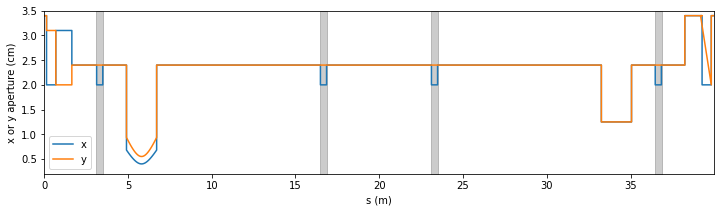

In [30]:
plt.figure(figsize=(12,3))
plt.plot(AP['x'][:,0],AP['x'][:,1]*100)
plt.plot(AP['y'][:,0],AP['y'][:,1]*100)
plt.fill_between(B30[:,0],B30[:,1]*100,color=(0,0,0),alpha=0.2)
plt.ylim((0.2,3.5))
plt.xlim((0.0,AP['x'][:,0].max()))
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

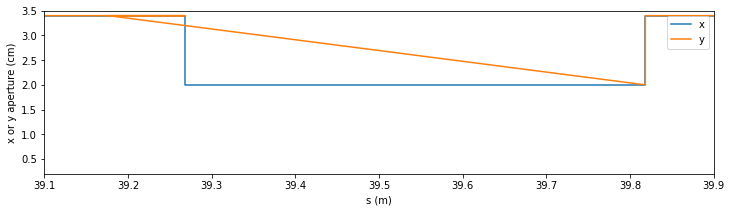

In [31]:
plt.figure(figsize=(12,3))
plt.plot(AP['x'][:,0],AP['x'][:,1]*100)
plt.plot(AP['y'][:,0],AP['y'][:,1]*100)
plt.fill_between(B30[:,0],B30[:,1]*100,color=(0,0,0),alpha=0.2)
plt.ylim((0.2,3.5))
plt.xlim((39.1,39.9))
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

# combine x-y aperture

In [32]:
aperture = []
jj=0
for i in range(len(AP['x'])):
    s = AP['x'][i,0]
    for j in range(jj,len(AP['y'])):
        if   s == AP['y'][j,0]:
            aperture.append([s,AP['x'][i,1],AP['y'][j,1],elliptic_])
            jj = j
            break
        elif s  < AP['y'][j,0]:
            aperture.append([s,AP['x'][i,1],AP['y'][j-1,1],elliptic_])
            jj = j
            break
        elif s  > AP['y'][j,0]:
            aperture.append([AP['y'][j,0],AP['x'][i-1,1],AP['y'][j,1],elliptic_])

            
duplicate = []
z=aperture[0][0]
for i in range(len(aperture)):
    if z>aperture[i][0]:
        duplicate.append(i)
    z=aperture[i][0]
        
for i in range(len(duplicate)):
    aperture.pop(duplicate[i]-i)

            
            
duplicate = []
for i in range(1,len(aperture)):
    if aperture[i]==aperture[i-1]:
        duplicate.append(i)

for i in range(len(duplicate)):
    aperture.pop(duplicate[i]-i)
    
duplicate = []
for i in range(1,len(aperture)-1):
    if aperture[i+1][0]==aperture[i][0]==aperture[i-1][0]:
        duplicate.append(i)
        
for i in range(len(duplicate)):
    aperture.pop(duplicate[i]-i)
    
    
duplicate = []
for i in range(1,len(aperture)-1):
    if aperture[i-1][1:3]==aperture[i][1:3]==aperture[i+1][1:3]:
        duplicate.append(i)
        
for i in range(len(duplicate)):
    aperture.pop(duplicate[i]-i)

    
aperture=np.array(aperture)
len(aperture)

79

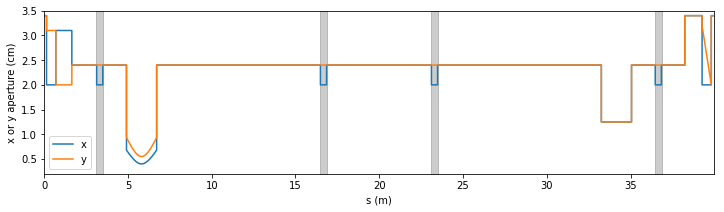

In [33]:
plt.figure(figsize=(12,3))
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)
plt.fill_between(B30[:,0],B30[:,1]*100,color=(0,0,0),alpha=0.2)
plt.ylim((0.2,3.5))
plt.xlim((0.0,AP['x'][:,0].max()))
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

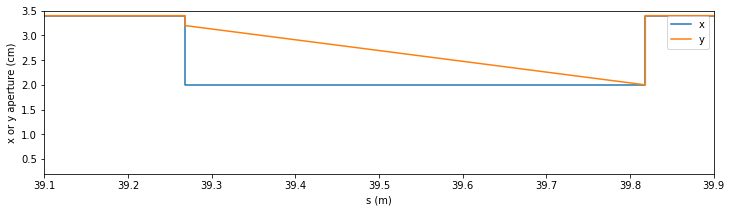

In [34]:
plt.figure(figsize=(12,3))
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)
plt.fill_between(B30[:,0],B30[:,1]*100,color=(0,0,0),alpha=0.2)
plt.ylim((0.2,3.5))
plt.ylim((0.2,3.5))
plt.xlim((39.1,39.9))
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

# define Aperture shape

In [35]:
jj = 0
for i in range(1,len(aperture)-1):
    for j in range(len(B30Loc)):
        if aperture[i  ,0] != aperture[i+1,0]:
            if (B30Loc[j][0]-0.0001 <= aperture[i  ,0] <= B30Loc[j][1]+0.0001 and
                B30Loc[j][0]-0.0001 <= aperture[i+1,0] <= B30Loc[j][1]+0.0001):
                aperture[i,  3] = rectangular_
                aperture[i+1,3] = rectangular_

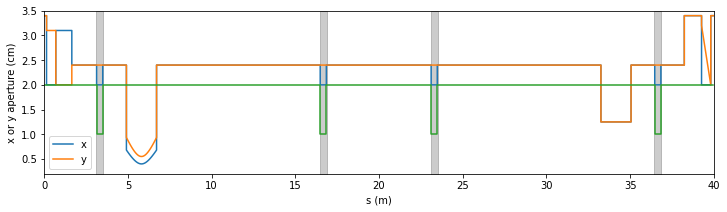

In [36]:
plt.figure(figsize=(12,3))
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)
plt.fill_between(B30[:,0],B30[:,1]*100,color=(0,0,0),alpha=0.2)
plt.plot(aperture[:,0],aperture[:,3])
plt.ylim((0.2,3.5))
plt.xlim((0.0,40))
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

In [37]:
aperture[:11,:]

array([[0.        , 0.034     , 0.034     , 2.        ],
       [0.14      , 0.034     , 0.034     , 2.        ],
       [0.14      , 0.02      , 0.031     , 2.        ],
       [0.6925    , 0.02      , 0.031     , 2.        ],
       [0.6925    , 0.031     , 0.02      , 2.        ],
       [1.65      , 0.031     , 0.02      , 2.        ],
       [1.65      , 0.024     , 0.024     , 2.        ],
       [3.13      , 0.024     , 0.024     , 2.        ],
       [3.13      , 0.02      , 0.024     , 1.        ],
       [3.49651914, 0.02      , 0.024     , 1.        ],
       [3.49651914, 0.024     , 0.024     , 2.        ]])

# Write pipeinfo

In [38]:
np.savetxt('pipeinfo.in',aperture)

# run Impact

In [39]:
for i in range(10):
    cleanLat.insert(-1-2*i,impact.getElem('multipole_thin'))
    
for i in range(26):
    n = np.random.randint(2,len(cleanLat)-20)
    cleanLat.insert(n,impact.getElem('multipole_thin'))

In [40]:
z = 0 
for item in cleanLat:
    if 'length' in item:
        item.n_sckick = int(np.ceil(lattice[i].length*40))
        z = z+item.length
    if item.type == 'quad':
        item.B1 = item.B1*(1.0+0.22*(np.random.rand()-0.5)*(0.7+z/L))
    if item.type == 'multipole_thin':
        item.KL_sext = (np.random.rand()-0.5)*44*(0.7+z/L)

In [41]:
cleanLat.insert(0,impact.getElem('pipeinfo'))
cleanLat[1].turns = 4

In [19]:
beam.distribution.alfx = 3.860846841e-5
beam.distribution.betx = 0.561065822
beam.distribution.alfy = 2.282987698e-9
beam.distribution.bety = 1.385141718
beam.distribution.emitx = 1.0e-7
beam.distribution.emity = 1.0e-7
beam.distribution.distribution_type = 'Gauss'
beam.n_particles = 320*1000*10
beam.nCore_y = 8
beam.nCore_z = 4

In [20]:
for item in lattice:
    if item.type == 'RFkick':
        item.vmax = 0.0

In [21]:
impact.writeInputFile(beam,cleanLat)
impact.run(beam)

0

In [58]:
# lostp = np.loadtxt('lost_partcl.data',skiprows=1, usecols=(0,1,2,4))
# np.save('lost_partcl',lostp)
lostp = np.load('lost_partcl.npy')

In [60]:
lostp[:,0] = np.mod(lostp[:,0],L)

In [61]:
len(lostp[:,0]),len(lostp[:,0])/beam.n_particles

(3191673, 31.168681640625)

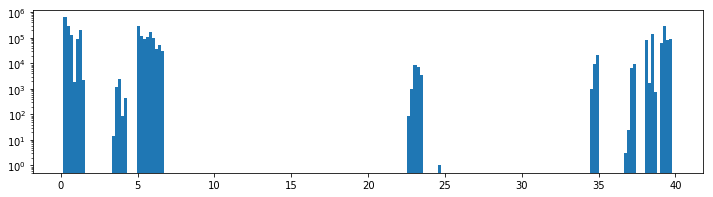

In [64]:
plt.figure(figsize=(12,3))
plt.hist(lostp[:,0],bins=200);
plt.yscale('log')

In [3]:
def getAperture(z):
    for i in range(1,len(aperture)-1):
        z0 = aperture[i,0]
        z1 = aperture[i+1,0]
        if z0 < z <= z1:
            break
    x = copy(aperture[i,:])
    _x = copy(aperture[i-1,:])
    if np.all(_x[1:] == x[1:]):
        _x = copy(aperture[i-2,:])
    x_ = copy(aperture[i+1,:])
    if np.all(x_[1:] == x[1:]):
        x_ = copy(aperture[i+2,:])
        
    x[1:3] = x[1:3]*100
    _x[1:3]= _x[1:3]*100
    x_[1:3]= x_[1:3]*100
    
    print('z0,z1=',z0,z1)
    print('_x =',_x )
    print(' x =', x )
    print(' x_=', x_)
    return z0,z1,_x,x,x_

def getPonAperture(z0,z1,dz):
    index = (z0+dz < lostp[:,0]) * (lostp[:,0] < z1-dz)
    return lostp[index,:]

def plotAperture(z,dz,xlim,ylim):
    z0,z1,_x,x,x_ = getAperture(z)
    ang = np.arange(0.0,2*np.pi,2*np.pi/2048)
    c = np.cos(ang)
    s = np.sin(ang)
    pData = getPonAperture(z0,z1,dz)
    print('nLost=',len(pData))
    plt.scatter(pData[:,1]*100,pData[:,2]*100,s=2.0,c='k')
    if x_[-1]==elliptic_:
        plt.plot(x_[1]*c,x_[2]*s,alpha=0.7,c='b',lw=2)
    else:
        plt.plot([-x_[1],x_[1],x_[1],-x_[1],-x_[1]],[x_[2],x_[2],-x_[2],-x_[2],x_[2]],alpha=0.7,c='b',lw=2)
    if _x[-1]==elliptic_:
        plt.plot(_x[1]*c,_x[2]*s,alpha=0.7,c='r',lw=2)
    else:
        plt.plot([-_x[1],_x[1],_x[1],-_x[1],-_x[1]],[_x[2],_x[2],-_x[2],-_x[2],_x[2]],alpha=0.7,c='r',lw=2)
    if x[-1]==elliptic_:
        plt.plot(x[1]*c,x[2]*s,c='g',lw=2)
    else:
        plt.plot([-x[1],x[1],x[1],-x[1],-x[1]],[x[2],x[2],-x[2],-x[2],x[2]],alpha=0.5,c='g',lw=2)
    plt.xlim(xlim)
    plt.ylim(ylim)

z0,z1= 0.6925 1.6500000000000001
_x = [0.6925 2.     3.1    2.    ]
 x = [0.6925 3.1    2.     2.    ]
 x_= [1.65 2.4  2.4  2.  ]
nLost= 303339
z0,z1= 0.6925 1.6500000000000001
_x = [0.6925 2.     3.1    2.    ]
 x = [0.6925 3.1    2.     2.    ]
 x_= [1.65 2.4  2.4  2.  ]
nLost= 303339


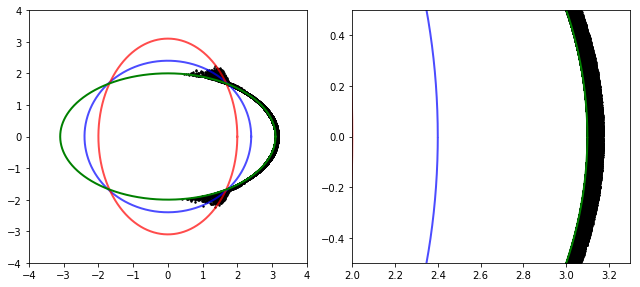

In [78]:
plt.figure(figsize=(9,4.1))
plt.subplot(1,2,1)
plotAperture(1, 0.0, (-4,4), (-4,4))
plt.subplot(1,2,2)
plotAperture(1, 0.0, (2,3.3), (-0.5,0.5));
plt.tight_layout()

In [33]:
B30Loc

[[3.098, 3.5285191429],
 [16.455595715500007, 16.886114858400006],
 [23.08211485840001, 23.51263400130001],
 [36.439710572900026, 36.87022971580003]]

z0,z1= 23.11411486 23.480634000000002
_x = [23.11411486  2.4         2.4         2.        ]
 x = [23.11411486  2.          2.4         1.        ]
 x_= [23.480634  2.4       2.4       2.      ]
nLost= 17506
z0,z1= 23.11411486 23.480634000000002
_x = [23.11411486  2.4         2.4         2.        ]
 x = [23.11411486  2.          2.4         1.        ]
 x_= [23.480634  2.4       2.4       2.      ]
nLost= 17506


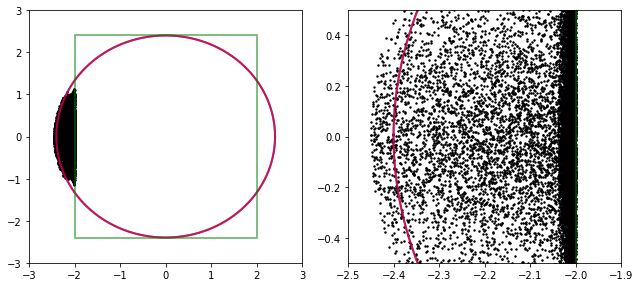

In [46]:
plt.figure(figsize=(9,4.1))
plt.subplot(1,2,1)
plotAperture(23.3, 0.0, (-3,3), (-3,3))
plt.subplot(1,2,2)
plotAperture(23.3, 0.001, (-2.5,-1.9), (-0.5,0.5));
plt.tight_layout()

z0,z1= 36.47171058 36.83822972
_x = [36.47171058  2.4         2.4         2.        ]
 x = [36.47171058  2.          2.4         1.        ]
 x_= [36.83822972  2.4         2.4         2.        ]
nLost= 27
z0,z1= 36.47171058 36.83822972
_x = [36.47171058  2.4         2.4         2.        ]
 x = [36.47171058  2.          2.4         1.        ]
 x_= [36.83822972  2.4         2.4         2.        ]
nLost= 27


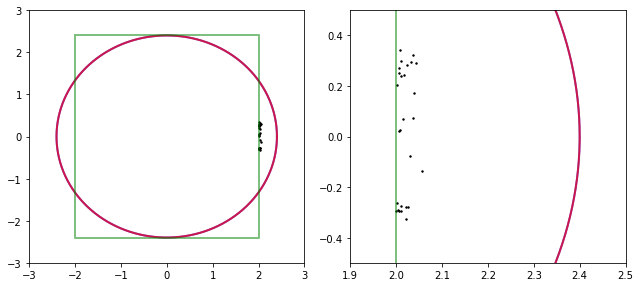

In [49]:
plt.figure(figsize=(9,4.1))
plt.subplot(1,2,1)
plotAperture(36.5, 0.0, (-3,3), (-3,3))
plt.subplot(1,2,2)
plotAperture(36.5, 0.001, (1.9,2.5), (-0.5,0.5));
plt.tight_layout()

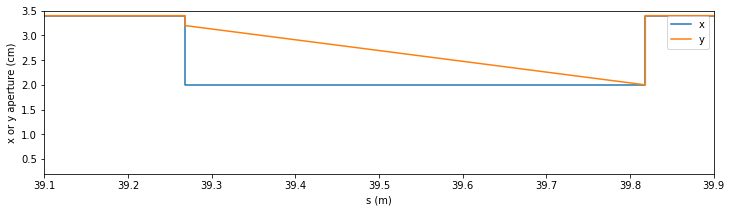

In [51]:
plt.figure(figsize=(12,3))
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)
plt.fill_between(B30[:,0],B30[:,1]*100,color=(0,0,0),alpha=0.2)
plt.ylim((0.2,3.5))
plt.ylim((0.2,3.5))
plt.xlim((39.1,39.9))
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

z0,z1= 39.26822972 39.81822972
_x = [39.26822972  3.4         3.4         2.        ]
 x = [39.26822972  2.          3.2         2.        ]
 x_= [39.81822972  2.          2.          2.        ]
nLost= 456248
z0,z1= 39.26822972 39.81822972
_x = [39.26822972  3.4         3.4         2.        ]
 x = [39.26822972  2.          3.2         2.        ]
 x_= [39.81822972  2.          2.          2.        ]
nLost= 456248
z0,z1= 39.26822972 39.81822972
_x = [39.26822972  3.4         3.4         2.        ]
 x = [39.26822972  2.          3.2         2.        ]
 x_= [39.81822972  2.          2.          2.        ]
nLost= 456248


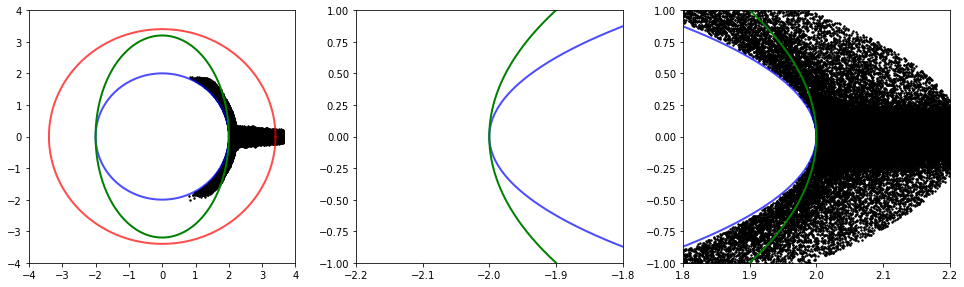

In [65]:
plt.figure(figsize=(13.5,4.1))
plt.subplot(1,3,1)
plotAperture(39.5, 0.001, (-4,4), (-4,4))
plt.subplot(1,3,2)
plotAperture(39.5, 0.001, (-2.2,-1.8), (-1,1));
plt.subplot(1,3,3)
plotAperture(39.5, 0.001, (1.8,2.2), (-1,1));
plt.tight_layout()

z0,z1= 39.26822972 39.81822972
_x = [39.26822972  3.4         3.4         2.        ]
 x = [39.26822972  2.          3.2         2.        ]
 x_= [39.81822972  2.          2.          2.        ]


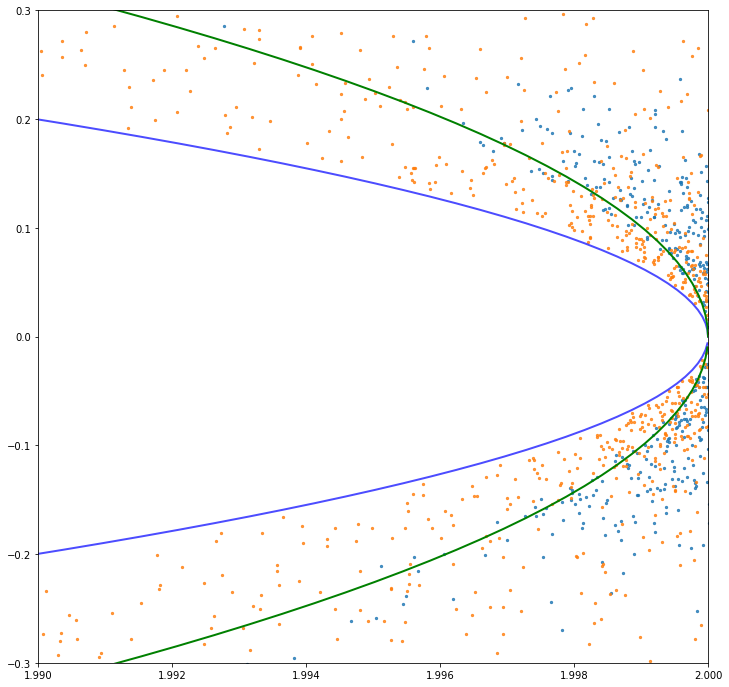

In [66]:
plt.figure(figsize=(12,12))

pData0 = getPonAperture(39.3,39.4,0.0001)*100
pData1 = getPonAperture(39.4,39.5,0.0001)*100
pData2 = getPonAperture(39.5,39.6,0.0001)*100
pData3 = getPonAperture(39.6,39.7,0.0001)*100
pData4 = getPonAperture(39.7,39.8,0.0001)*100
plt.scatter(pData0[:,1],pData0[:,2],s=5.2,alpha=0.8)
# plt.scatter(pData1[:,1],pData1[:,2],s=5.2,alpha=0.8)
# plt.scatter(pData2[:,1],pData2[:,2],s=5.2,alpha=0.8)
# plt.scatter(pData3[:,1],pData3[:,2],s=5.2,alpha=0.8)
plt.scatter(pData4[:,1],pData4[:,2],s=5.2,alpha=0.8)


z0,z1,_x,x,x_ = getAperture(39.5)
ang = np.arange(0.0,2*np.pi,2*np.pi/2048)
c = np.cos(ang)
s = np.sin(ang)
if x_[-1]==elliptic_:
    plt.plot(x_[1]*c,x_[2]*s,alpha=0.7,c='b',lw=2)
else:
    plt.plot([-x_[1],x_[1],x_[1],-x_[1],-x_[1]],[x_[2],x_[2],-x_[2],-x_[2],x_[2]],alpha=0.7,c='b',lw=2)
if _x[-1]==elliptic_:
    plt.plot(_x[1]*c,_x[2]*s,alpha=0.7,c='r',lw=2)
else:
    plt.plot([-_x[1],_x[1],_x[1],-_x[1],-_x[1]],[_x[2],_x[2],-_x[2],-_x[2],_x[2]],alpha=0.7,c='r',lw=2)
if x[-1]==elliptic_:
    plt.plot(x[1]*c,x[2]*s,c='g',lw=2)
else:
    plt.plot([-x[1],x[1],x[1],-x[1],-x[1]],[x[2],x[2],-x[2],-x[2],x[2]],alpha=0.5,c='g',lw=2)
    
plt.xlim(1.99,2.0);
plt.ylim(-0.3,0.3);